In [1]:
import os
import sys
from pathlib import Path

cwd_path = cwd_path = Path(os.getcwd()).absolute().parents[0]
parent_path = cwd_path.parents[0]
sys.path.insert(0, parent_path.as_posix())
sys.path.insert(0, cwd_path.parents[0].parents[0].as_posix()) # Root

import numpy as np
from scipy.io import loadmat  # loading data from matlab
from mayavi import mlab
import matplotlib.pyplot as plt
from pymanopt.manifolds import Euclidean, Sphere, Product

from SkillsSequencing.skills.mps.gmr.manifold_statistics import compute_frechet_mean, compute_weighted_frechet_mean
from SkillsSequencing.skills.mps.gmr.manifold_clustering import manifold_k_means, manifold_gmm_em
from SkillsSequencing.skills.mps.gmr.manifold_gmr import manifold_gmr
from SkillsSequencing.utils.plot_sphere_mayavi import plot_sphere, plot_gaussian_mesh_on_tangent_plane

from SkillsSequencing.skills.mps.dynsys.CALVIN_DS import CALVINDynSysDataset
from SkillsSequencing.skills.mps.dynsys.utils import plot_3d_trajectories

### Load Data

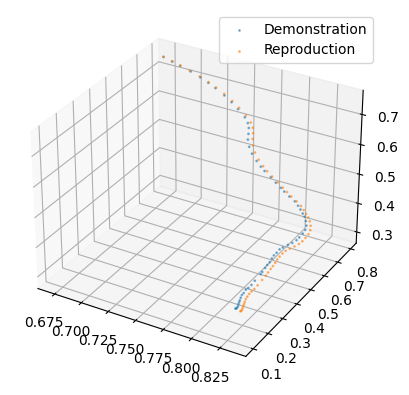

In [2]:
dataset = CALVINDynSysDataset(skill='open_drawer', state_type='pos', train=True, normalized=True, goal_centered=True, demos_dir='data/')
dataset.plot_random()

In [3]:
np.min(dataset.X.numpy().reshape(-1, dataset.X.shape[-1]), axis=0)

array([0.03141584, 0.        , 0.        ], dtype=float32)

In [4]:
np.max(dataset.X.numpy().reshape(-1, dataset.X.shape[-1]), axis=0)

array([0.99390817, 0.97508115, 0.9929931 ], dtype=float32)

### Parameters

In [5]:
dataset.X[0].shape[0]

62

In [6]:
nb_data = dataset.X[0].shape[0]
nb_data_sup = 62
nb_samples = 10
dt = 0.06
sampling_dt = 0.03
input_dim = 3
output_dim = 3
in_idx = [0, 1, 2]
out_idx = [3, 4, 5]
nb_states = 3

In [7]:
# Create velocity data
# demos_dx = np.array([(demos[i][2:, :] - demos[i][:-2, :])/dt for i in range(nb_samples)])
# demos = [demos[i][1:-1, :] for i in range(nb_samples)]

# Stack position and velocity data
demos_xdx = [np.hstack([dataset.X[i], dataset.dX[i]]) for i in range(nb_samples)]

# Stack demos
demos_np = demos_xdx[0]
for i in range(1, nb_samples):
    demos_np = np.vstack([demos_np, demos_xdx[i]])

In [8]:
demos_np.shape

(620, 6)

In [9]:
X = demos_np[:, :input_dim]
Y = demos_np[:, input_dim:]

# X_mins = np.min(X, axis=0)
# X_maxs = np.max(X, axis=0)

# X = 2 * (X - X_mins)/ (X_maxs - X_mins) - 1
# X = X / np.linalg.norm(X, axis=1)[:, None]

# Y_mins = np.min(Y, axis=0)
# Y_maxs = np.max(Y, axis=0)
# Y = 2 * (Y - Y_mins)/ (Y_maxs - Y_mins) - 1
# Y = Y / np.linalg.norm(Y, axis=1)[:, None]

In [10]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
# plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                  X[p * nb_data:(p + 1) * nb_data, 1],
                  X[p * nb_data:(p + 1) * nb_data, 2],
                  color=(0., 0., 0.),
                  scale_factor=0.01)
mlab.view(30, 120)
mlab.show()

In [11]:
# mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
# fig = mlab.gcf()
# mlab.clf()
# # plot_sphere(figure=fig)
# # Plot data on the sphere
# for p in range(nb_samples):
#     if Y.shape[-1] == 2:
#         mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
#                       Y[p * nb_data:(p + 1) * nb_data, 1],
#                       np.ones(Y[p * nb_data:(p + 1) * nb_data, 1].shape),
#                       color=(0., 0., 0.),
#                       scale_factor=0.03)
#     else:
#         mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
#                       Y[p * nb_data:(p + 1) * nb_data, 1],
#                       Y[p * nb_data:(p + 1) * nb_data, 2],
#                       color=(0., 0., 0.),
#                       scale_factor=0.03)
# mlab.view(30, 120)
# mlab.show()

In [12]:
# Data in format compatible with pymanopt product of manifolds
data = np.empty((X.shape[0], 2), dtype=object)
for n in range(X.shape[0]):
    data[n] = [X[n], Y[n]]

In [13]:
# Xt = dt * np.arange(nb_data + nb_data_sup)[:, None]

# Create the manifold
input_manifold = Euclidean(input_dim)
# output_manifold = Sphere(output_dim)
output_manifold = Euclidean(output_dim)
manifold = Product([input_manifold, output_manifold])

# Number of clusters
nb_clusters = 3

In [14]:
# K-means
km_means, km_assignments = manifold_k_means(manifold, data, nb_clusters=nb_clusters)

# GMM
initial_covariances = np.concatenate(nb_clusters * [np.eye(input_dim+output_dim)[None]], 0)
initial_priors = np.zeros(nb_clusters)
for k in range(nb_clusters):
    initial_priors[k] = np.sum(km_assignments == k) / len(km_assignments)
gmm_means, gmm_covariances, gmm_priors, gmm_assignments = manifold_gmm_em(manifold, data, nb_clusters,
                                                                          initial_means=km_means,
                                                                          initial_covariances=initial_covariances,
                                                                          initial_priors=initial_priors)
outdir = f'skill_ds/{dataset.state_type}/{dataset.skill}/gmm/'
os.makedirs(outdir, exist_ok=True)
filename = outdir + 'gmm_params.npz'
np.savez(filename, gmm_means=gmm_means, gmm_covariances=gmm_covariances, gmm_priors=gmm_priors)

Converged after 19 iterations: 5.655e+00


In [15]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
# plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                  X[p * nb_data:(p + 1) * nb_data, 1],
                  X[p * nb_data:(p + 1) * nb_data, 2],
                  color=(0., 0., 0.),
                  scale_factor=0.005)
# # Plot Gaussians
for k in range(nb_clusters):
    mlab.points3d(gmm_means[k, 0][0],
                  gmm_means[k, 0][1],
                  gmm_means[k, 0][2],
                  color=(1, 0., 0.),
                  scale_factor=0.010)
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 0], gmm_covariances[k, :input_dim, :input_dim], color=(0.5, 0, 0.2))
mlab.view(30, 120)
mlab.show()

In [16]:
val_dataset = CALVINDynSysDataset(skill='open_drawer', state_type='pos', normalized=False, train=False, goal_centered=False, demos_dir='data/')

### Option 0 (Normalized)

sampling_dt = 0.03
X_val = val_dataset.X[0]
for i in range(1, val_dataset.X.shape[0]):
    X_val = np.vstack([X_val, val_dataset.X[i]])
 
rand_idx = np.random.choice(np.arange(0, len(X_val), nb_data))
sampled_path = []
x0 = np.copy(X_val[rand_idx, :])
goal = np.copy(X_val[rand_idx+nb_data-1, :])
new_x = x0
for i in range(200):
    x_dot, sigma_gmr, H = manifold_gmr((new_x-goal).reshape(1, -1), manifold, gmm_means, gmm_covariances, gmm_priors)
    new_x = new_x + sampling_dt * x_dot
    sampled_path.append(new_x-goal)
    if np.linalg.norm(new_x - goal) <= 0.02:
        break
sampled_path = np.array(sampled_path).squeeze(1)
print(rand_idx, len(sampled_path))

x0 = x0 - goal
goal = goal - goal

### Option 1 (First norm then goal centered)

sampling_dt = 0.03
X_val = val_dataset.X[0]
for i in range(1, val_dataset.X.shape[0]):
    X_val = np.vstack([X_val, val_dataset.X[i]])

rand_idx = np.random.choice(np.arange(0, len(X_val), nb_data))
sampled_path = []
x0 = np.copy(X_val[rand_idx, :])
goal = np.copy(X_val[rand_idx+nb_data-1, :])
goal = dataset.normalize(goal)
new_x = x0
new_x = dataset.normalize(new_x)

for i in range(100):
    x_dot, sigma_gmr, H = manifold_gmr((new_x-goal).reshape(1, -1), manifold, gmm_means, gmm_covariances, gmm_priors)
    new_x = new_x + sampling_dt * x_dot
    sampled_path.append(new_x-goal)
    if np.linalg.norm(new_x-goal) <= 0.035:
        break
sampled_path = np.array(sampled_path).squeeze(1)
print(rand_idx, len(sampled_path))

x0 = dataset.normalize(x0) - goal
goal = goal - goal

### Option 2 (First goal c then norm)

In [20]:
sampling_dt = 0.03
X_val = val_dataset.X[0]
for i in range(1, val_dataset.X.shape[0]):
    X_val = np.vstack([X_val, val_dataset.X[i]])

rand_idx = np.random.choice(np.arange(0, len(X_val), nb_data))
sampled_path = []
x0 = np.copy(X_val[rand_idx, :])
goal = np.copy(X_val[rand_idx+nb_data-1, :])
new_x = x0

for i in range(100):
    x_dot, sigma_gmr, H = manifold_gmr(dataset.normalize(new_x-goal).reshape(1, -1), manifold, gmm_means, gmm_covariances, gmm_priors)
    sampled_path.append(dataset.normalize(new_x-goal) + sampling_dt * x_dot)
    new_x = dataset.normalize(new_x-goal) + sampling_dt * x_dot
    new_x = dataset.undo_normalize(new_x) + goal 
    if np.linalg.norm(new_x - goal) <= 0.03:
        break
sampled_path = np.array(sampled_path).squeeze(1)
print(rand_idx, len(sampled_path))

x0 = dataset.normalize(x0-goal)
goal = dataset.normalize(goal-goal)

744 72


## Input Space

In [21]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
# plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                  X[p * nb_data:(p + 1) * nb_data, 1],
                  X[p * nb_data:(p + 1) * nb_data, 2],
                  color=(0., 0., 0.),
                  scale_factor=0.005)
# # Plot Gaussians
for k in range(nb_clusters):
    mlab.points3d(gmm_means[k, 0][0],
                  gmm_means[k, 0][1],
                  gmm_means[k, 0][2],
                  color=(1, 0., 0.),
                  scale_factor=0.010)
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 0], gmm_covariances[k, :input_dim, :input_dim], color=(0.5, 0, 0.2))

# Plot sampled trajectory
mlab.points3d(x0[0], x0[1], x0[2],
              color=(0.78, 0.08, 0.44),
              scale_factor=0.010)
mlab.points3d(goal[0], goal[1], goal[2],
              color=(0.0, 1, 0.0),
              scale_factor=0.010)
for k in range(len(sampled_path)):
    mlab.points3d(sampled_path[k, 0],
                  sampled_path[k, 1],
                  sampled_path[k, 2],
                  color=(0.20, 0.54, 0.93),
                  scale_factor=0.007)

mlab.view(30, 120)
mlab.show()

## Output Space

In [74]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
# plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                  Y[p * nb_data:(p + 1) * nb_data, 1],
                  Y[p * nb_data:(p + 1) * nb_data, 2],
                  color=(0., 0., 0.),
                  scale_factor=0.03)
    
# Plot Gaussians
for k in range(nb_clusters):
    mlab.points3d(gmm_means[k, 1][0],
                  gmm_means[k, 1][1],
                  gmm_means[k, 1][2],
                  color=(1, 0., 0.),
                  scale_factor=0.05)
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 1], gmm_covariances[k, input_dim:, input_dim:], color=(0.5, 0, 0.2))

# Plot GMR trajectory
# for n in range(sa.shape[0]):
#     # Plot mean and covariance
#     plot_gaussian_mesh_on_tangent_plane(mu_gmr[n], sigma_gmr[n], color=(0.20, 0.54, 0.93))
#     # Plot mean only
#     mlab.points3d(mu_gmr[n, 0], mu_gmr[n, 1], mu_gmr[n, 2],
#                   color=(0.20, 0.54, 0.93),
#                   scale_factor=0.03)
mlab.view(30, 120)
mlab.show()

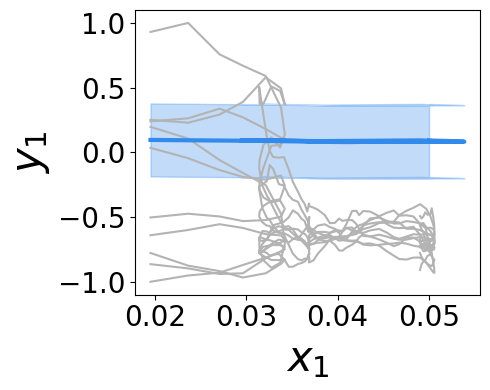

In [47]:
plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    if nb_samples == 5:
        nb_data = 190
    plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 0], color=[.7, .7, .7])
plt.plot(Xt[:, 0], mu_gmr[:, 0], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 0] - np.sqrt(sigma_gmr[:, 0, 0])
maxy = mu_gmr[:, 0] + np.sqrt(sigma_gmr[:, 0, 0])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$x_1$', fontsize=30)
plt.ylabel('$y_1$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure1.png', dpi=100)

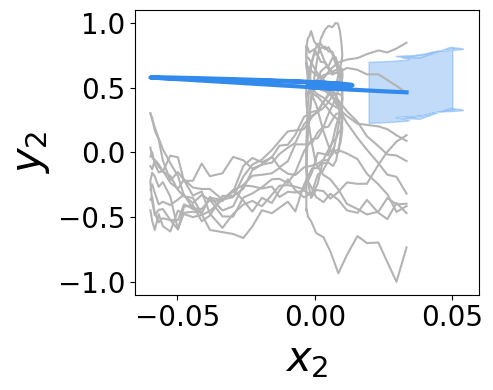

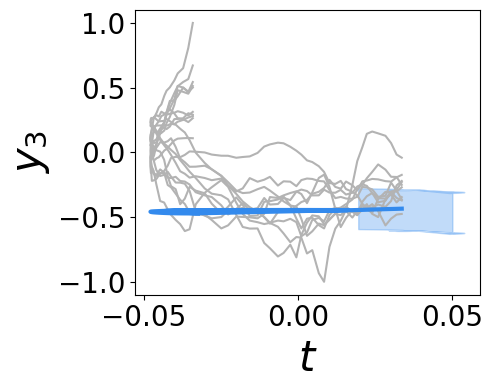

In [48]:
plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    if nb_samples == 5:
        nb_data = 190
    plt.plot(Xt[:nb_data, 1], Y[p * nb_data:(p + 1) * nb_data, 1], color=[.7, .7, .7])
plt.plot(Xt[:, 1], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 1] - np.sqrt(sigma_gmr[:, 1, 1])
maxy = mu_gmr[:, 1] + np.sqrt(sigma_gmr[:, 1, 1])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$x_2$', fontsize=30)
plt.ylabel('$y_2$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure2.png', dpi=100)
# plt.show()

plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    if nb_samples == 5:
        nb_data = 190
    plt.plot(Xt[:nb_data, 2], Y[p * nb_data:(p + 1) * nb_data, 2], color=[.7, .7, .7])
plt.plot(Xt[:, 2], mu_gmr[:, 2], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 2] - np.sqrt(sigma_gmr[:, 2, 2])
maxy = mu_gmr[:, 2] + np.sqrt(sigma_gmr[:, 2, 2])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_3$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure3.png', dpi=100)